# f2e_inj (FACET-II electron injector) Reference simulation

In [1]:
%pylab --no-import-all inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from impact import Impact
from distgen import Generator
import os

NAME = 'impact_f2e_inj_v0_1M_particles'

GFILE = os.path.expandvars('$FACET2_LATTICE/distgen/models/f2e_inj/v0/distgen.yaml')
YFILE = os.path.expandvars('$FACET2_LATTICE/impact/models/f2e_inj/v0/ImpactT.yaml')

In [3]:
assert os.path.exists(GFILE)
assert os.path.exists(YFILE)

In [5]:
%%time
G = Generator(GFILE)
G['n_particle'] = 1_000_000
G.run()
P0 = G.particles

CPU times: user 7.52 s, sys: 280 ms, total: 7.8 s
Wall time: 7.8 s


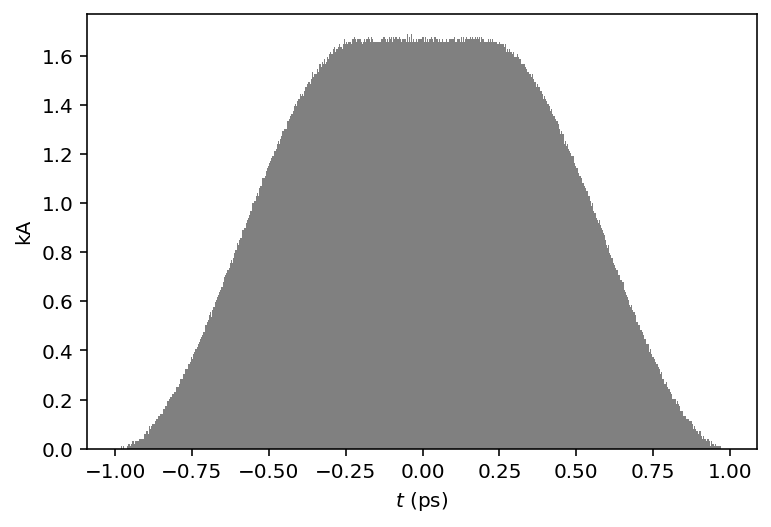

In [6]:
P0.plot('t')

# MPI run 1M particles

For this many particles we will prepare an MPI run

In [7]:
I = Impact.from_yaml(YFILE)

# Set initial particles
I.initial_particles = P0

## Switches for MPI
I.numprocs = 128
#I.stop = 1.4
I.mpi_run

'mpirun -n {n} {command_mpi}'

In [8]:
# Change some things
I.header['Nx'] = 64
I.header['Ny'] = 64
I.header['Nz'] = 64

# Run on Cori (NERSC)

In [9]:
%%time
I.command_mpi = '/global/homes/c/cmayes/cori/impact/bin/ImpactTv2.1_mpi'
I.workdir = os.path.expandvars('$SCRATCH')
I.mpi_run = 'salloc -N 4 -C haswell -q interactive -t 04:00:00 srun -n {n} {command_mpi} >log.txt' 
I.configure()

I.run()

salloc: Granted job allocation 53240806
salloc: Waiting for resource configuration
salloc: Nodes nid00[272-275] are ready for job
salloc: Relinquishing job allocation 53240806


CPU times: user 1min 15s, sys: 2.23 s, total: 1min 17s
Wall time: 8min 47s


# Run on SDF (SLAC)

This will run on SLAC's SDF. Note that you must have access to a partition (allocation) for instant response.

In [ ]:
 # SDF setup    

PARTITION = 'ard' 
    
settings = { 
 'command': '/gpfs/slac/staas/fs1/g/g.beamphysics/cmayes/impact/ImpactTexe',    
 'command_mpi': '/gpfs/slac/staas/fs1/g/g.beamphysics/cmayes/impact/ImpactTexe-mpi',
 'mpi_run': 'salloc --partition '+f'{PARTITION}'+' -N 1 -n {n} /sdf/sw/gcc-4.8.5/openmpi-4.0.4/bin/mpirun -n {n} {command_mpi}'
   }
for k, v in settings.items():
    I[k] = v
    
I.workdir = os.path.expandvars('$SCRATCH')
I.configure()


In [ ]:
%%time
I.run()

# Plot

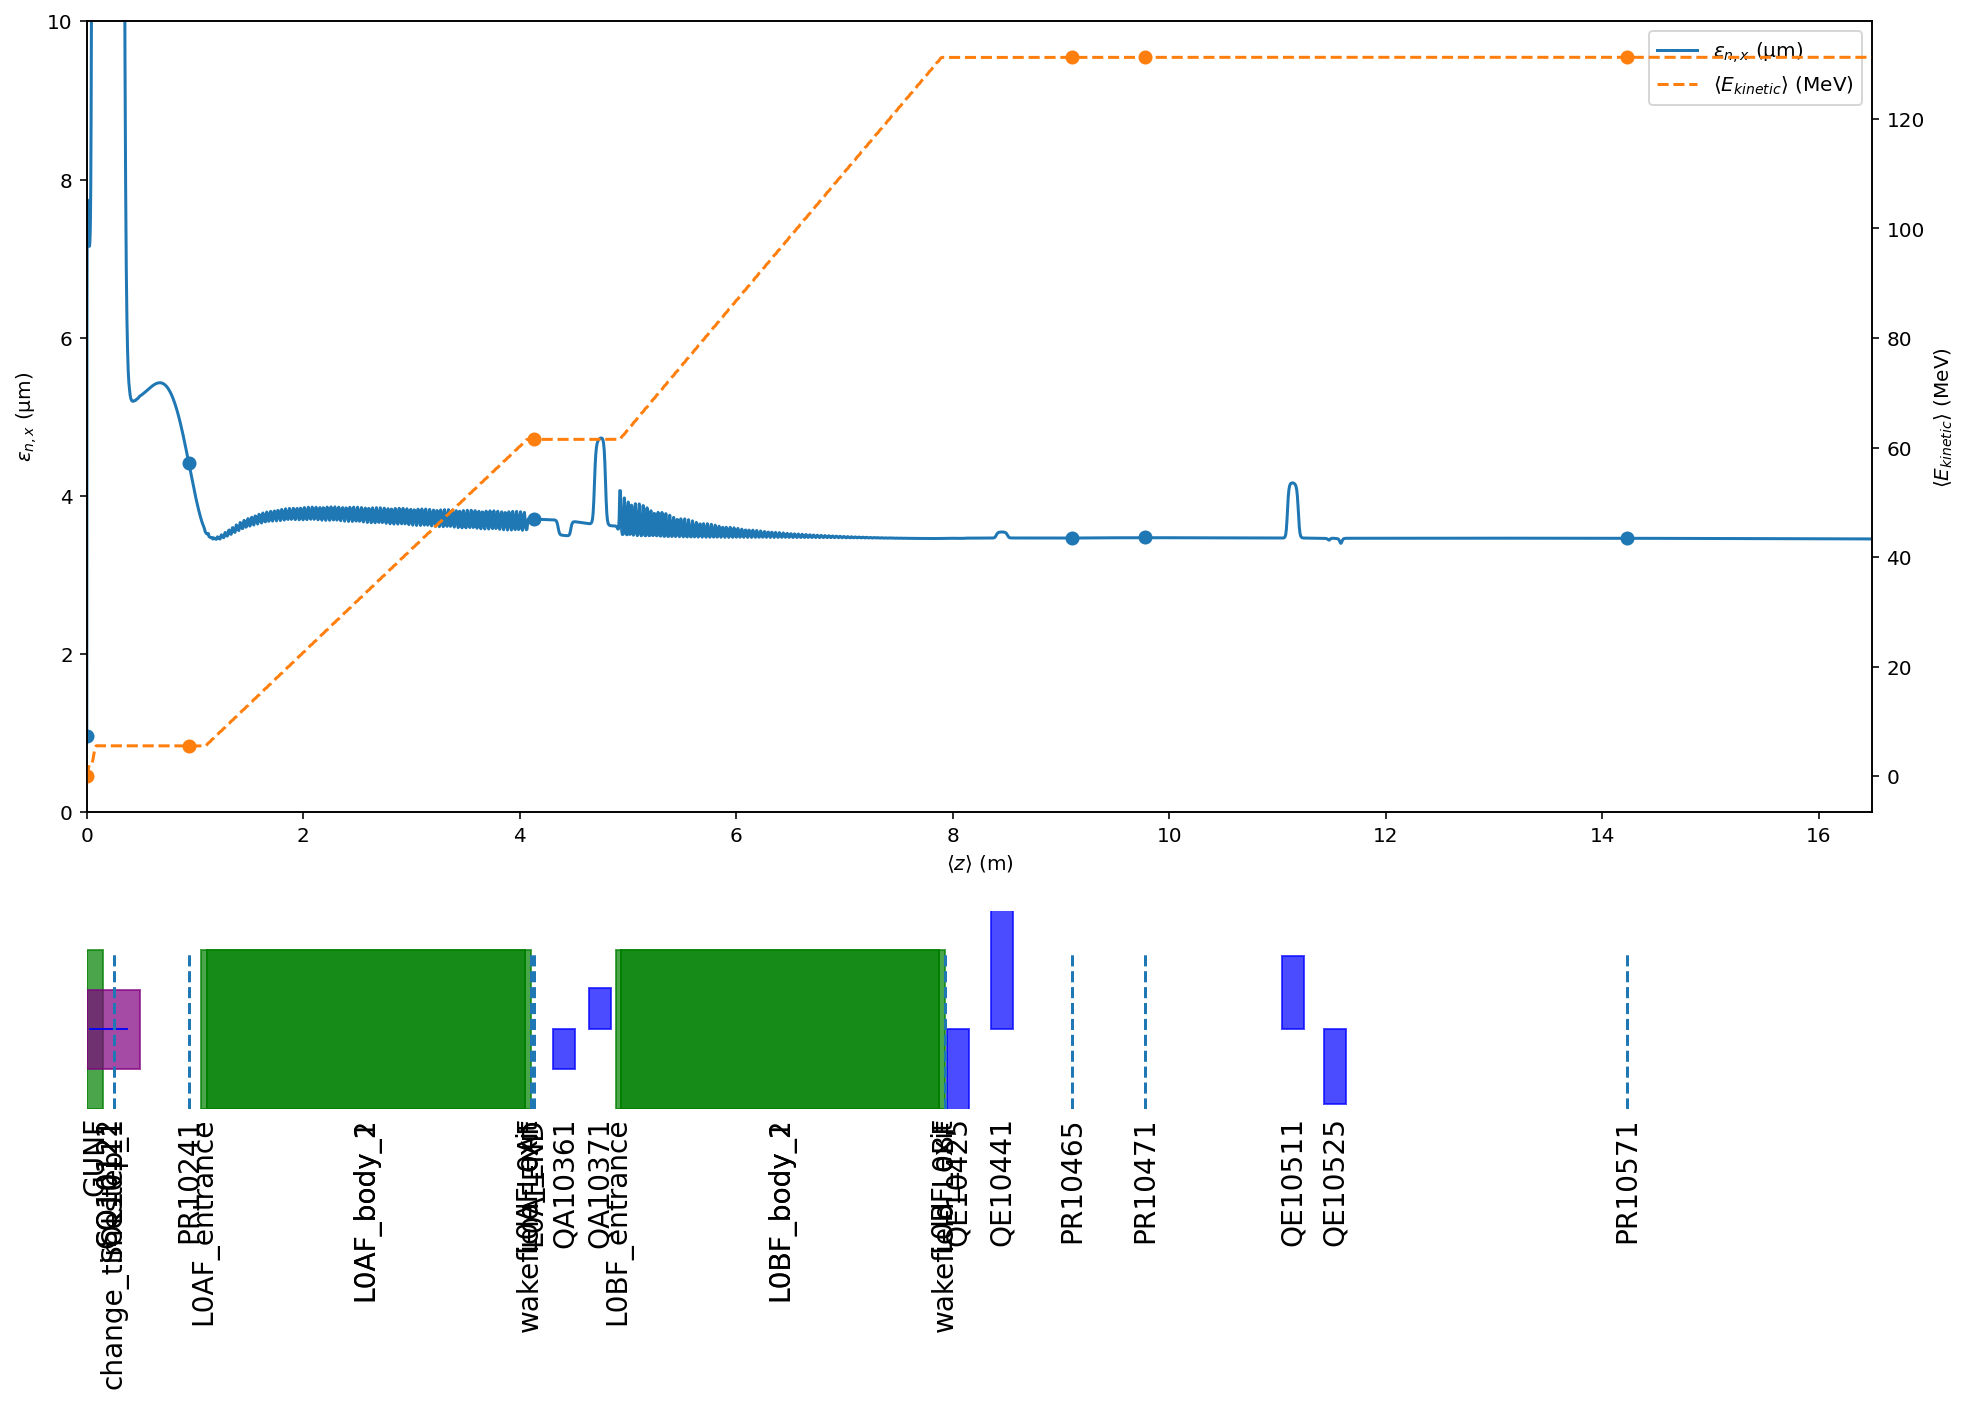

In [11]:
I.plot('norm_emit_x', y2='mean_kinetic_energy', ylim=(0, 10e-6), figsize=(16,10), include_labels=True)

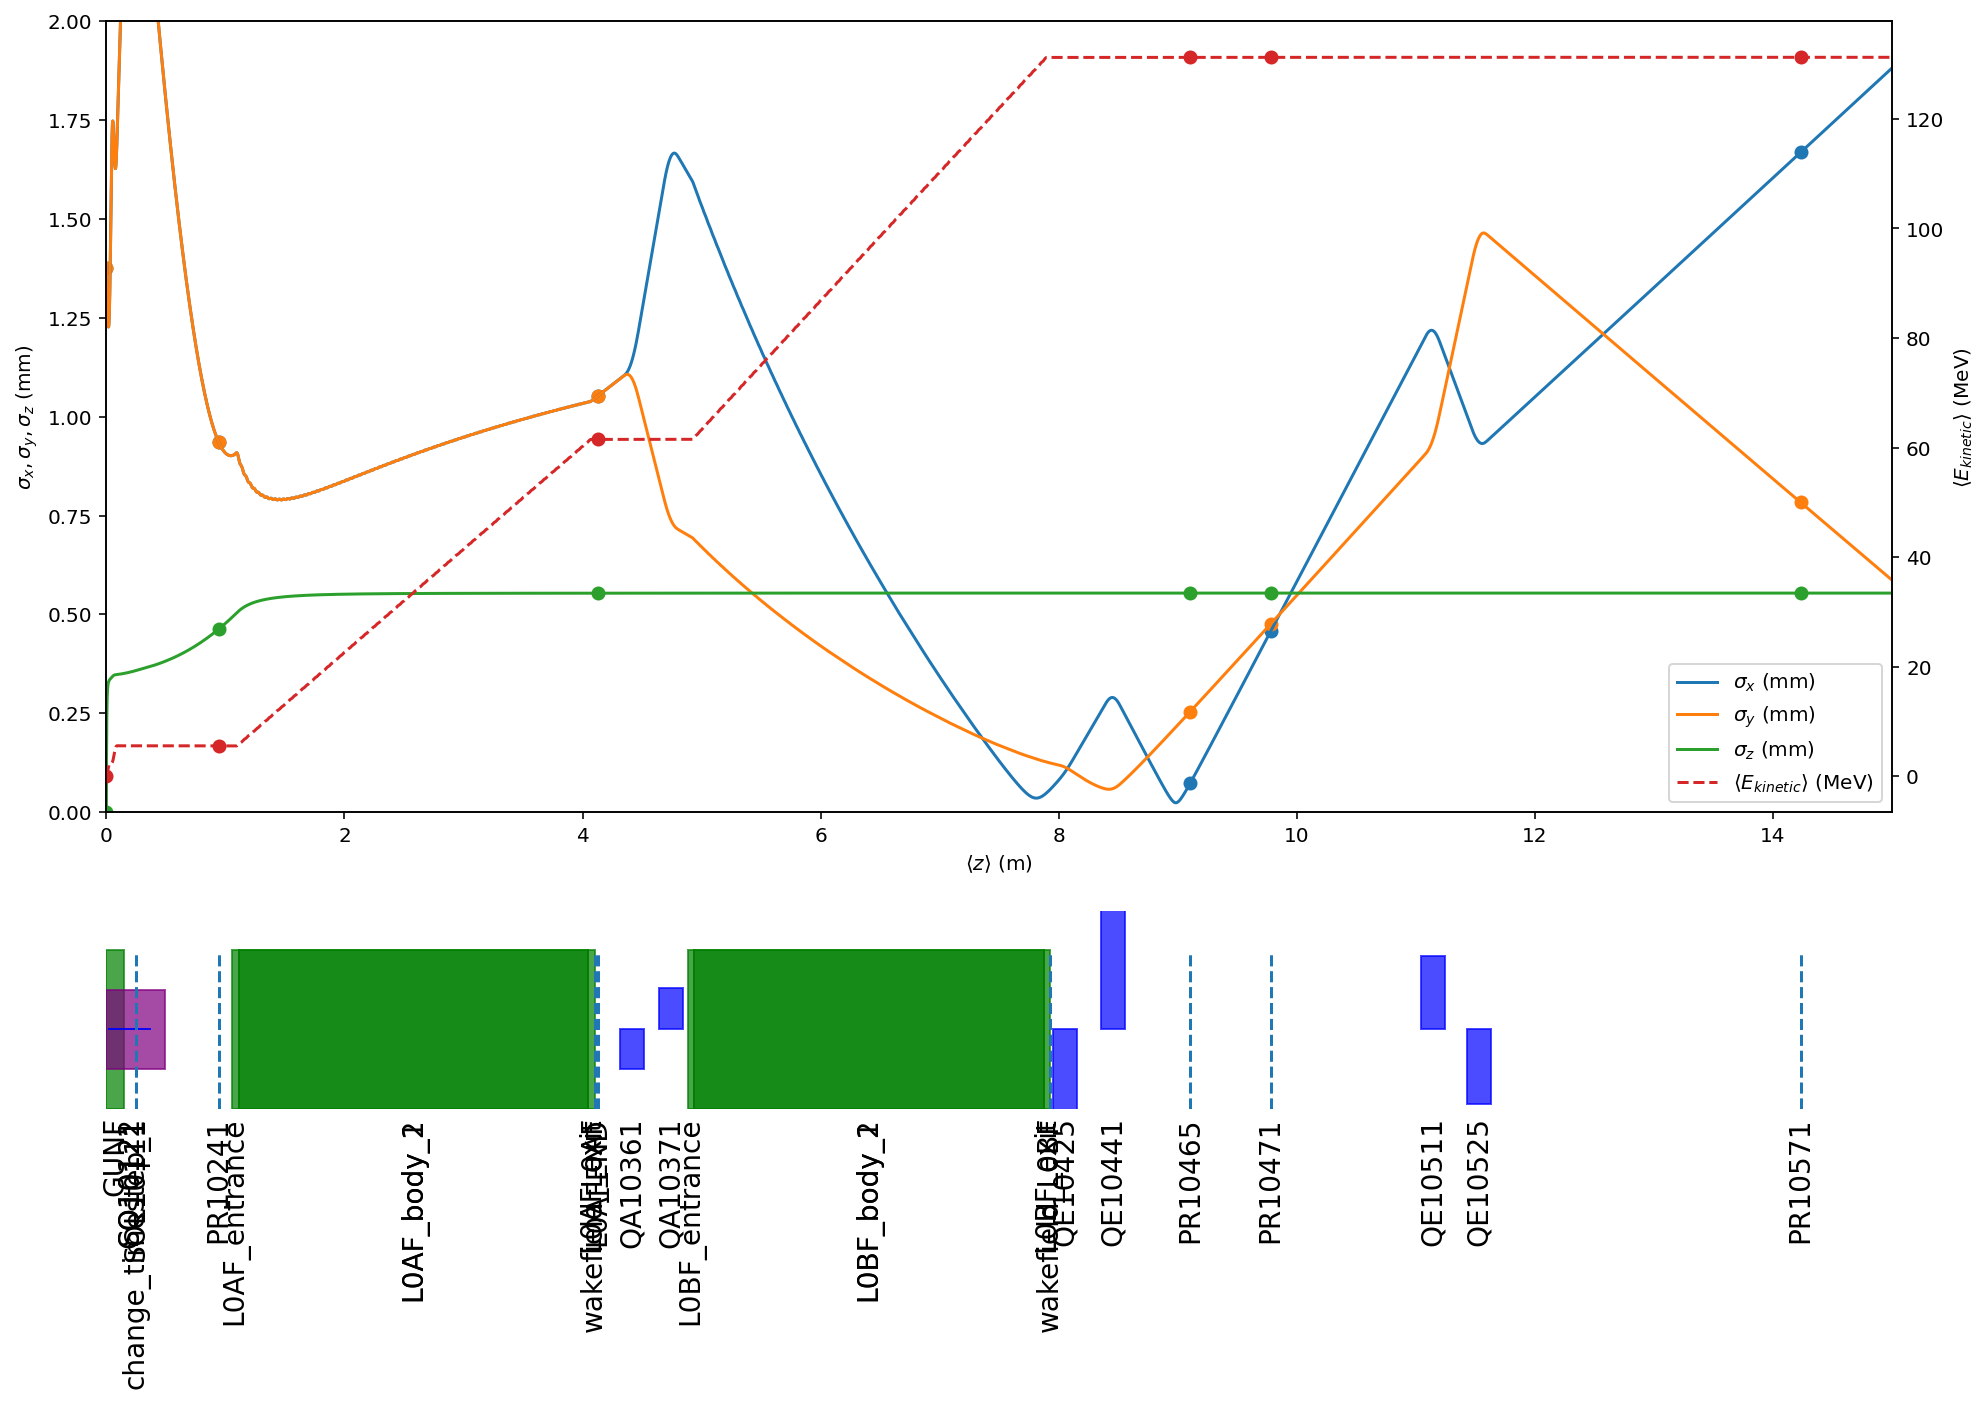

In [12]:
I.plot(['sigma_x', 'sigma_y', 'sigma_z'], y2='mean_kinetic_energy',  ylim=(0, 0.002), xlim=(0, 15), figsize=(16,10), include_labels=True)

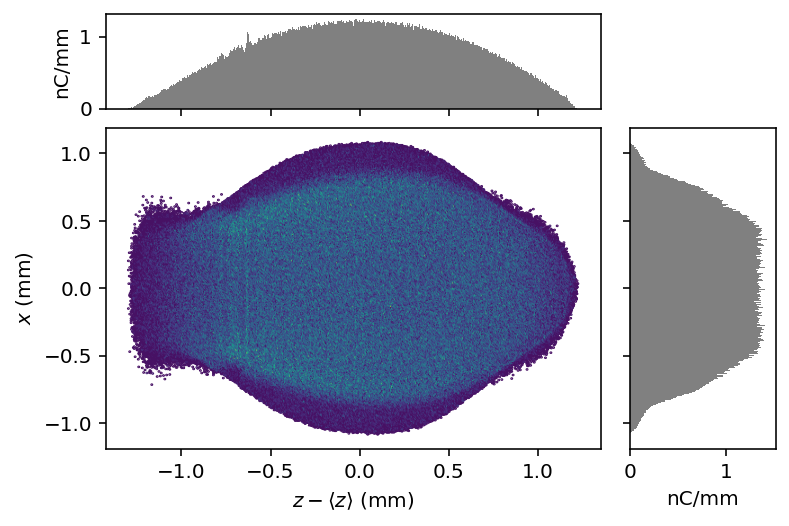

In [13]:
P1 = I.particles['PR10471']

P1.plot('delta_z', 'x')

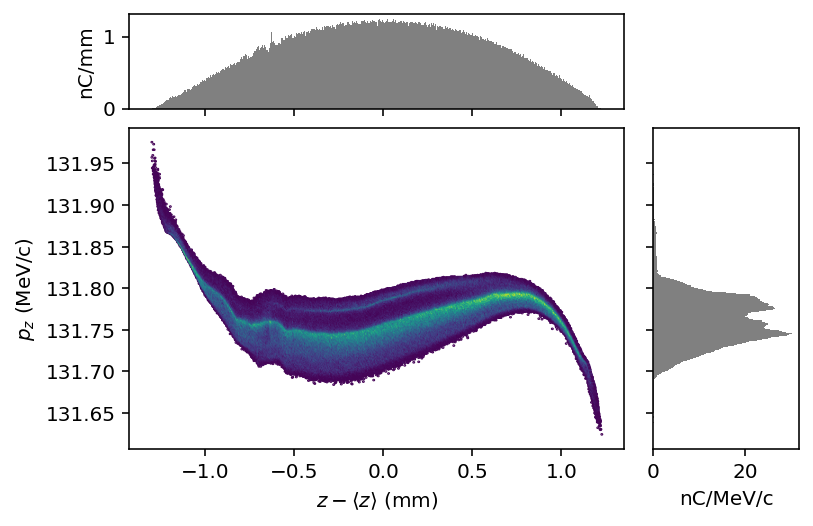

In [14]:
P1.plot('delta_z', 'pz')

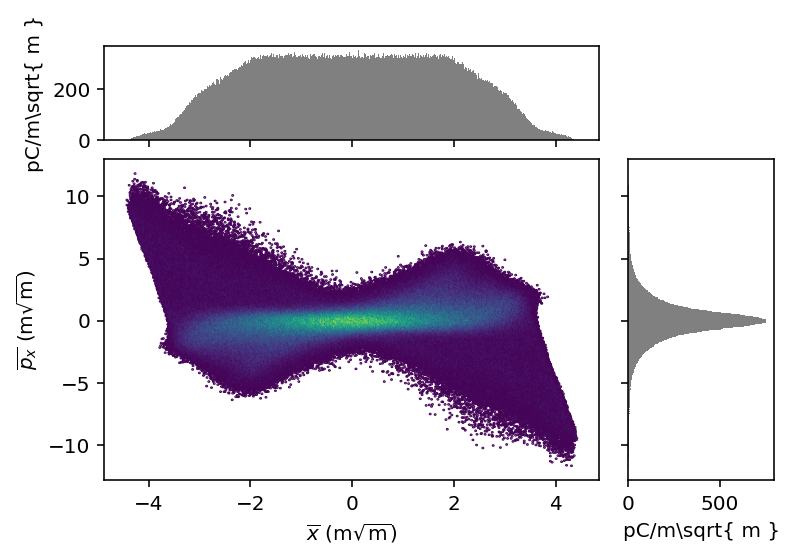

In [15]:
P1.plot('x_bar', 'px_bar')

In [16]:
# 95% Twiss and Emittance
P1.twiss('xy', 0.95)

{'alpha_x': -27.157434439510354,
 'beta_x': 21.36694364354477,
 'gamma_x': 34.563962804264776,
 'emit_x': 8.68019584012987e-09,
 'eta_x': 0.0004866113377335205,
 'etap_x': 0.0006107089114939173,
 'norm_emit_x': 2.2381657395032692e-06,
 'alpha_y': -14.670642665420639,
 'beta_y': 20.607335928998637,
 'gamma_y': 10.492756412641615,
 'emit_y': 9.146295124841618e-09,
 'eta_y': 3.486797536425526e-05,
 'etap_y': -2.2386387134055104e-05,
 'norm_emit_y': 2.358350005093856e-06}

In [ ]:
# Copy basic input to `v0/`
# !cp {I.path}/ImpactT.in {os.path.split(YFILE)[0]}
# !cp {I.path}/partcl.data {os.path.split(YFILE)[0]}

In [17]:
#%%time
#afile = f'/global/cfs/cdirs/m669/www/lume/f2e_inj/{NAME}.h5'
#I.archive(afile)

'/global/cfs/cdirs/m669/www/lume/f2e_inj/impact_f2e_inj_v0_1M_particles.h5'

# WWW archive access

In [19]:
# Restore
!wget https://portal.nersc.gov/cfs/m669/lume/f2e_inj/{NAME}.h5

--2022-01-16 14:29:23--  https://portal.nersc.gov/cfs/m669/lume/f2e_inj/impact_f2e_inj_v0_1M_particles.h5
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.106, 128.55.206.113, 128.55.206.110, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 385381184 (368M)
Saving to: ‘impact_f2e_inj_v0_1M_particles.h5’

impact_f2e_inj_v0_1 100%[===================>] 367.53M   218MB/s    in 1.7s    

2022-01-16 14:29:24 (218 MB/s) - ‘impact_f2e_inj_v0_1M_particles.h5’ saved [385381184/385381184]



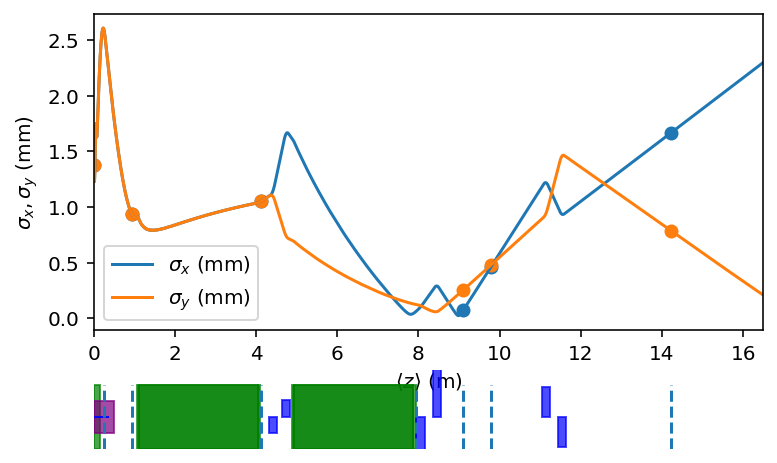

In [25]:
I2 = Impact.from_archive(f'{NAME}.h5')
I2.plot()

In [26]:
I.particles

{'final_particles': <ParticleGroup with 1000000 particles at 0x2aaae1f605b0>,
 'initial_particles': <ParticleGroup with 1000000 particles at 0x2aaaee675ca0>,
 'PR10241': <ParticleGroup with 1000000 particles at 0x2aaaee6753d0>,
 'L0AFEND': <ParticleGroup with 1000000 particles at 0x2aaaee6751c0>,
 'PR10465': <ParticleGroup with 1000000 particles at 0x2aaaee6759a0>,
 'PR10471': <ParticleGroup with 1000000 particles at 0x2aaaee675490>,
 'PR10571': <ParticleGroup with 1000000 particles at 0x2aaaee675970>}

# Prepare for Bmad

In [32]:
P1 = I.particles['L0AFEND'].copy()
P1 = P1.resample(100_000)
P1.drift_to_z()
P1.z[:] = 0
P1.t[:] -= P1['mean_t']
P1['mean_energy']

61998201.5093176

In [33]:
bfile = os.path.expandvars('$FACET2_LATTICE/bmad/beams/L0AFEND.h5')
P1.write(bfile)